# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [120]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# read in the json files
#portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)


In [121]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [122]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [123]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [124]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [125]:
profile.shape

(17000, 5)

In [126]:
def id_mapper2(df,feature,newname):
    coded_dict = dict()
    cter = 1
    feature_encoded = []
    
    for val in df[feature]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        feature_encoded.append(coded_dict[val])
    df[newname]=feature_encoded
    df=df.drop([feature],axis=1)
    return df

In [127]:
def id_mapper(df,feature):
    coded_dict = dict()
    cter = 1
    feature_encoded = []
    
    for val in df[feature]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        feature_encoded.append(coded_dict[val])
    return feature_encoded



In [128]:
feature_encoded = id_mapper(portfolio,'id')
del portfolio['id']
portfolio['offer_ID'] = feature_encoded
portfolio

,channels,difficulty,duration,offer_type,reward,offer_ID
0,"[email, mobile, social]",10,7,bogo,10,1
1,"[web, email, mobile, social]",10,5,bogo,10,2
2,"[web, email, mobile]",0,4,informational,0,3
3,"[web, email, mobile]",5,7,bogo,5,4
4,"[web, email]",20,10,discount,5,5
5,"[web, email, mobile, social]",7,7,discount,3,6
6,"[web, email, mobile, social]",10,10,discount,2,7
7,"[email, mobile, social]",0,3,informational,0,8
8,"[web, email, mobile, social]",5,5,bogo,5,9
9,"[web, email, mobile]",10,7,discount,2,10


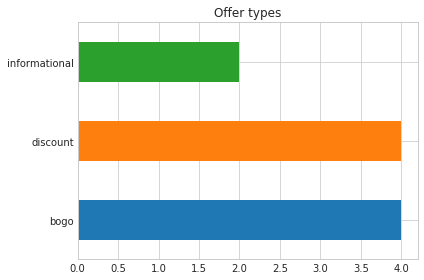

In [129]:
offer_vals = portfolio.offer_type.value_counts()[:10].plot(kind="barh");

#(gender_vals/full_data.shape[0]).plot(kind="bar"); 

plt.title("Offer types");
plt.tight_layout()
plt.savefig('offer types.png', dpi=300)

In [130]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [131]:
profile[profile.age==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [132]:
profile=profile[profile.age != 118]


In [133]:
profile.shape

(14825, 5)

In [134]:
portfolio.head()

,channels,difficulty,duration,offer_type,reward,offer_ID
0,"[email, mobile, social]",10,7,bogo,10,1
1,"[web, email, mobile, social]",10,5,bogo,10,2
2,"[web, email, mobile]",0,4,informational,0,3
3,"[web, email, mobile]",5,7,bogo,5,4
4,"[web, email]",20,10,discount,5,5


In [135]:
def col_split(df, column):
    splits = []
    for s in df[column]:
        for i in s:
            if i not in splits:
                splits.append(i)
    for split in splits:
        df[split] = df[column].apply(lambda x: 1 if split in x else 0)
        
    df.drop([column], axis=1, inplace=True) 
    
    return splits

In [136]:
col_split(portfolio,'channels')

['email', 'mobile', 'social', 'web']

In [137]:
portfolio

,difficulty,duration,offer_type,reward,offer_ID,email,mobile,social,web
0,10,7,bogo,10,1,1,1,1,0
1,10,5,bogo,10,2,1,1,1,1
2,0,4,informational,0,3,1,1,0,1
3,5,7,bogo,5,4,1,1,0,1
4,20,10,discount,5,5,1,0,0,1
5,7,7,discount,3,6,1,1,1,1
6,10,10,discount,2,7,1,1,1,1
7,0,3,informational,0,8,1,1,1,0
8,5,5,bogo,5,9,1,1,1,1
9,10,7,discount,2,10,1,1,0,1


In [138]:
portfolio['duration']=portfolio['duration']*24


In [139]:
portfolio

,difficulty,duration,offer_type,reward,offer_ID,email,mobile,social,web
0,10,168,bogo,10,1,1,1,1,0
1,10,120,bogo,10,2,1,1,1,1
2,0,96,informational,0,3,1,1,0,1
3,5,168,bogo,5,4,1,1,0,1
4,20,240,discount,5,5,1,0,0,1
5,7,168,discount,3,6,1,1,1,1
6,10,240,discount,2,7,1,1,1,1
7,0,72,informational,0,8,1,1,1,0
8,5,120,bogo,5,9,1,1,1,1
9,10,168,discount,2,10,1,1,0,1


In [140]:
#customer_encoded = id_mapper(profile,'id')
customer_encoded = id_mapper(profile,'id')
del profile['id']
profile['customer_id'] = customer_encoded


In [141]:

# show header
profile.head()

,age,became_member_on,gender,income,customer_id
1,55,20170715,F,112000.0,1
3,75,20170509,F,100000.0,2
5,68,20180426,M,70000.0,3
8,65,20180209,M,53000.0,4
12,58,20171111,M,51000.0,5


In [142]:
#Formating 'became member' to a data format
profile['membership_start'] = profile.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
#profile['membership_period'] = profile_clean['membership_start'].dt.to_period('M')
profile.drop(['became_member_on'], axis=1, inplace=True)

In [143]:
profile.head()

,age,gender,income,customer_id,membership_start
1,55,F,112000.0,1,2017-07-15
3,75,F,100000.0,2,2017-05-09
5,68,M,70000.0,3,2018-04-26
8,65,M,53000.0,4,2018-02-09
12,58,M,51000.0,5,2017-11-11


In [144]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [145]:
#transform the 'value' dict column in a key colum and value colums
df_final = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1).drop('value', axis = 1)


In [146]:
df_final

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [149]:
df_final.amount.sum()

1775451.9700000004

In [148]:
df_final=df_final.fillna(0)

In [150]:
#Create a transanctions dataframe
df_transactions=df_final[df_final['event']=='transaction']

In [151]:
#Removing transactions from df_final
df_final = df_final[df_final.event != 'transaction']

In [152]:
df_transactions

,event,person,time,offer id,amount,offer_id,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0,0.83,0,0.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,34.56,0,0.0
12659,transaction,54890f68699049c2a04d415abc25e717,0,0,13.23,0,0.0
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,0,19.51,0,0.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,0,18.97,0,0.0
12678,transaction,629fc02d56414d91bca360decdfa9288,0,0,33.90,0,0.0
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,0,0.22,0,0.0
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,0,18.59,0,0.0
12691,transaction,676506bad68e4161b9bbaffeb039626b,0,0,18.01,0,0.0
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,0,19.11,0,0.0


In [153]:
df_transactions.amount.sum()

1775451.9699999997

In [154]:
#integrating in one column 'offer_id' and 'offer id'
mask=df_final['offer_id'] == 0
df_final.loc[mask, 'offer_id'] = df_final.loc[mask, 'offer id']

In [155]:
df_final.drop('offer id',axis=1,inplace=True)

In [36]:
#df_test=df_final.iloc[0:25, :]

In [156]:
df_final

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0
6,offer received,c4863c7985cf408faee930f111475da3,0,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,0.0,3f207df678b143eea3cee63160fa8bed,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0


In [157]:
#How many types of offers we have?
df_final.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [158]:
#Mapping offer_id field
offer_encoded = id_mapper(df_final,'offer_id')
del df_final['offer_id']
df_final['offer_ID'] = offer_encoded

In [159]:
df_final

,event,person,time,amount,reward,offer_ID
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0.0,1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0.0,2
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,0.0,3
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,0.0,4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,0.0,5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,0.0,0.0,6
6,offer received,c4863c7985cf408faee930f111475da3,0,0.0,0.0,7
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,0.0,0.0,8
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0.0,0.0,2
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0.0,0.0,2


In [160]:
#Mapping the 'person' column that is equal to customer id
person_encoded = id_mapper(df_final,'person')
del df_final['person']
df_final['customer_id'] = person_encoded

In [161]:
df_final

,event,time,amount,reward,offer_ID,customer_id
0,offer received,0,0.0,0.0,1,1
1,offer received,0,0.0,0.0,2,2
2,offer received,0,0.0,0.0,3,3
3,offer received,0,0.0,0.0,4,4
4,offer received,0,0.0,0.0,5,5
5,offer received,0,0.0,0.0,6,6
6,offer received,0,0.0,0.0,7,7
7,offer received,0,0.0,0.0,8,8
8,offer received,0,0.0,0.0,2,9
9,offer received,0,0.0,0.0,2,10


In [162]:
df_offers=df_final.drop(['amount','reward'],axis=1)

In [163]:
df_offers.rename(columns={"time": "offer_time"},inplace=True)

In [164]:
df_offers

,event,offer_time,offer_ID,customer_id
0,offer received,0,1,1
1,offer received,0,2,2
2,offer received,0,3,3
3,offer received,0,4,4
4,offer received,0,5,5
5,offer received,0,6,6
6,offer received,0,7,7
7,offer received,0,8,8
8,offer received,0,2,9
9,offer received,0,2,10


In [165]:
df_event=df_final.copy()

In [166]:
df_event.drop(['time', 'reward', 'amount' , 'customer_id'],axis=1,inplace=True)

In [167]:
df_event

,event,offer_ID
0,offer received,1
1,offer received,2
2,offer received,3
3,offer received,4
4,offer received,5
5,offer received,6
6,offer received,7
7,offer received,8
8,offer received,2
9,offer received,2


In [168]:
df_grupy=df_event.groupby(['offer_ID', 'event'])['event'].count().unstack("event")

In [169]:
df_grupy=df_grupy.rename_axis(None, axis=1)

In [170]:
df_grupy.shape

(10, 3)

In [171]:
#Delete some offers that have NaNs, dont know why
#df_grupy.dropna(axis='index')
df_grupy

,offer completed,offer received,offer viewed
offer_ID,,,
1,4354.0,7677.0,4171.0
2,3420.0,7668.0,2663.0
3,4017.0,7632.0,4118.0
4,5317.0,7597.0,7327.0
5,3331.0,7593.0,7298.0
6,4296.0,7571.0,7264.0
7,5156.0,7646.0,7337.0
8,NaN,7617.0,4144.0
9,3688.0,7658.0,6716.0


In [172]:
df_grupy=df_grupy.fillna(0)

In [173]:
df_grupy['perc_completed']=df_grupy['offer completed']/df_grupy['offer received']

In [174]:
df_grupy['perc_viewed']=df_grupy['offer viewed']/df_grupy['offer received']

In [175]:
df_grupy['complete not viewed']=df_grupy['offer completed']-df_grupy['offer viewed']

In [176]:
df_grupy.head()

,offer completed,offer received,offer viewed,perc_completed,perc_viewed,complete not viewed
offer_ID,,,,,,
1,4354.0,7677.0,4171.0,0.567149,0.543311,183.0
2,3420.0,7668.0,2663.0,0.446009,0.347287,757.0
3,4017.0,7632.0,4118.0,0.526336,0.539570,-101.0
4,5317.0,7597.0,7327.0,0.699882,0.964460,-2010.0
5,3331.0,7593.0,7298.0,0.438694,0.961148,-3967.0


In [177]:
df_transactions.head()

,event,person,time,offer id,amount,offer_id,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0,0.83,0,0.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,34.56,0,0.0
12659,transaction,54890f68699049c2a04d415abc25e717,0,0,13.23,0,0.0
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,0,19.51,0,0.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,0,18.97,0,0.0


In [178]:
df_transactions.drop(['event','offer id','offer_id', 'reward'],axis=1,inplace=True)

In [179]:
df_transactions.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [180]:
feature_encoded = id_mapper(df_transactions,'person')
del df_transactions['person']
df_transactions['customer_id'] = feature_encoded

In [181]:
df_transactions.head()

,time,amount,customer_id
12654,0,0.83,1
12657,0,34.56,2
12659,0,13.23,3
12670,0,19.51,4
12671,0,18.97,5


In [182]:
df_transactions.rename(columns={"time": "time_trans"},inplace=True)
df_transactions.head()

,time_trans,amount,customer_id
12654,0,0.83,1
12657,0,34.56,2
12659,0,13.23,3
12670,0,19.51,4
12671,0,18.97,5


In [183]:
df_transactions.amount.sum()

1775451.9699999997

In [184]:
df_grupy

,offer completed,offer received,offer viewed,perc_completed,perc_viewed,complete not viewed
offer_ID,,,,,,
1,4354.0,7677.0,4171.0,0.567149,0.543311,183.0
2,3420.0,7668.0,2663.0,0.446009,0.347287,757.0
3,4017.0,7632.0,4118.0,0.526336,0.539570,-101.0
4,5317.0,7597.0,7327.0,0.699882,0.964460,-2010.0
5,3331.0,7593.0,7298.0,0.438694,0.961148,-3967.0
6,4296.0,7571.0,7264.0,0.567428,0.959451,-2968.0
7,5156.0,7646.0,7337.0,0.674340,0.959587,-2181.0
8,0.0,7617.0,4144.0,0.000000,0.544046,-4144.0
9,3688.0,7658.0,6716.0,0.481588,0.876991,-3028.0


In [185]:
df_offers.head()

,event,offer_time,offer_ID,customer_id
0,offer received,0,1,1
1,offer received,0,2,2
2,offer received,0,3,3
3,offer received,0,4,4
4,offer received,0,5,5


In [186]:
full_data = pd.merge(pd.merge(pd.merge(profile,df_transactions, on='customer_id'), df_offers, on='customer_id'), 
                df_grupy, on='offer_ID')

In [187]:
full_data = pd.merge(full_data,portfolio, on='offer_ID')

In [188]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1364119 entries, 0 to 1364118
Data columns (total 24 columns):
age                    1364119 non-null int64
gender                 1364119 non-null object
income                 1364119 non-null float64
customer_id            1364119 non-null int64
membership_start       1364119 non-null datetime64[ns]
time_trans             1364119 non-null int64
amount                 1364119 non-null float64
event                  1364119 non-null object
offer_time             1364119 non-null int64
offer_ID               1364119 non-null int64
offer completed        1364119 non-null float64
offer received         1364119 non-null float64
offer viewed           1364119 non-null float64
perc_completed         1364119 non-null float64
perc_viewed            1364119 non-null float64
complete not viewed    1364119 non-null float64
difficulty             1364119 non-null int64
duration               1364119 non-null int64
offer_type             1364119 n

In [190]:
full_data.shape

(1364119, 24)

In [192]:
full_data = full_data[full_data['time_trans'] <= full_data['duration']]

In [193]:
full_data.shape

(278216, 24)

Text(6.8,0.5,'# of events')

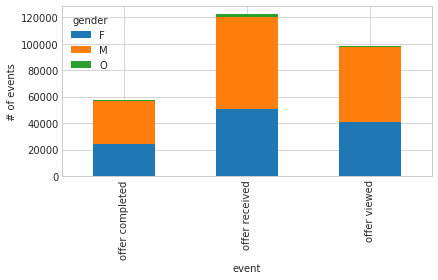

In [217]:
full_data.groupby(['event','gender']).size().unstack().plot(kind='bar', stacked=True)
#plt.title("Offer types and events");
plt.tight_layout()
plt.savefig('Events and offers.png', dpi=300)
plt.ylabel('# of events')

Text(6.8,0.5,'# of completed offers')

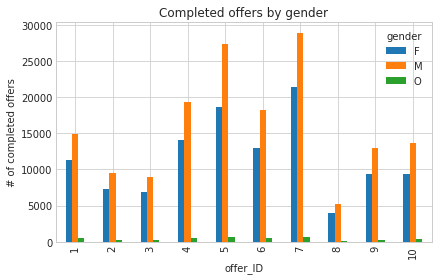

In [219]:
full_data.groupby(['offer_ID','gender'])['offer completed'].count().unstack().plot(kind='bar')
plt.title("Completed offers by gender");
plt.tight_layout()
plt.savefig('Gender and offers2.png', dpi=300)
plt.ylabel('# of completed offers')
#plt.ylabel('# Offers Completed')

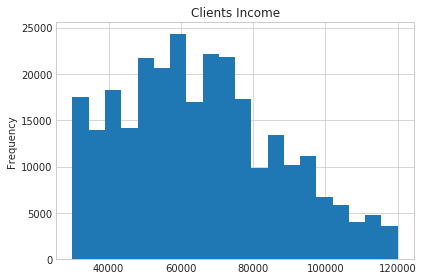

In [196]:
full_data['income'].plot.hist( bins=20)
plt.title("Clients Income");
plt.tight_layout()
plt.savefig('Histo Clients Income.png', dpi=300)

In [213]:
#pd.cut(profile['age'], bins=8, labels=False)

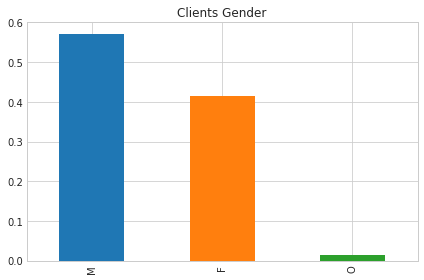

In [197]:
gender_vals = full_data.gender.value_counts()[:10]

(gender_vals/full_data.shape[0]).plot(kind="bar"); 

plt.title("Clients Gender");
plt.tight_layout()
plt.savefig('ClientsGender.png', dpi=300)

In [92]:
full_data.head()

,age,gender,income,customer_id,membership_start,time_trans,amount,event,offer_time,offer_ID,...,perc_viewed,complete not viewed,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,F,112000.0,1,2017-07-15,0,0.83,offer received,0,1,...,0.543311,183.0,10,168.0,bogo,10,1,1,1,0
1,55,F,112000.0,1,2017-07-15,0,0.83,offer viewed,6,1,...,0.543311,183.0,10,168.0,bogo,10,1,1,1,0
2,55,F,112000.0,1,2017-07-15,0,0.83,offer completed,132,1,...,0.543311,183.0,10,168.0,bogo,10,1,1,1,0
3,55,F,112000.0,1,2017-07-15,6,1.44,offer received,0,1,...,0.543311,183.0,10,168.0,bogo,10,1,1,1,0
4,55,F,112000.0,1,2017-07-15,6,1.44,offer viewed,6,1,...,0.543311,183.0,10,168.0,bogo,10,1,1,1,0


In [108]:
df_transactions.head()

,time_trans,amount,customer_id
12654,0,0.83,1
12657,0,34.56,2
12659,0,13.23,3
12670,0,19.51,4
12671,0,18.97,5


In [117]:
portfolio

,difficulty,duration,offer_type,reward,offer_ID,email,mobile,social,web
0,10,168.0,bogo,10,1,1,1,1,0
1,10,120.0,bogo,10,2,1,1,1,1
2,0,96.0,informational,0,3,1,1,0,1
3,5,168.0,bogo,5,4,1,1,0,1
4,20,240.0,discount,5,5,1,0,0,1
5,7,168.0,discount,3,6,1,1,1,1
6,10,240.0,discount,2,7,1,1,1,1
7,0,72.0,informational,0,8,1,1,1,0
8,5,120.0,bogo,5,9,1,1,1,1
9,10,168.0,discount,2,10,1,1,0,1


In [198]:
full_data.groupby('offer_ID')['amount'].sum().sort_values()

offer_ID
8     125224.98
3     200423.51
2     209433.76
9     285998.04
10    298135.57
1     345788.33
6     383067.47
4     428505.40
5     590383.49
7     654964.92
Name: amount, dtype: float64

In [199]:
full_data[full_data.offer_type=='bogo'].groupby('offer_ID')['amount'].sum()

offer_ID
1    345788.33
2    209433.76
4    428505.40
9    285998.04
Name: amount, dtype: float64

Text(0.5,21.7063,'Transaction Amount')

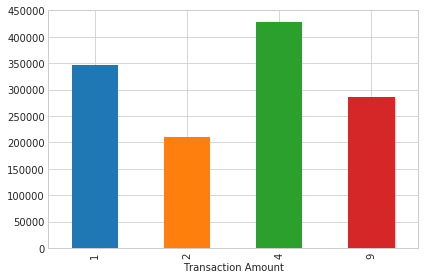

In [200]:
full_data[full_data.offer_type=='bogo'].groupby('offer_ID')['amount'].sum().plot(kind='bar')
plt.tight_layout()
plt.savefig('BOGO Transaction amount.png', dpi=300)
plt.xlabel('Transaction Amount')

Text(0.5,21.7063,'Transaction Amount')

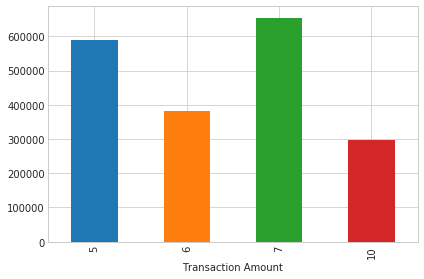

In [201]:
full_data[full_data.offer_type=='discount'].groupby('offer_ID')['amount'].sum().plot(kind='bar')
plt.tight_layout()
plt.savefig('Discount Transaction amount.png', dpi=300)
plt.xlabel('Transaction Amount')

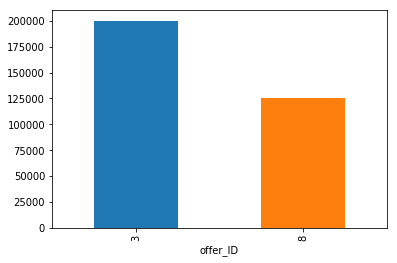

In [121]:
full_data[full_data.offer_type=='informational'].groupby('offer_ID')['amount'].sum().sort_values(ascending=False).plot(kind='bar')

Text(6.8,0.5,'Transaction Amount $')

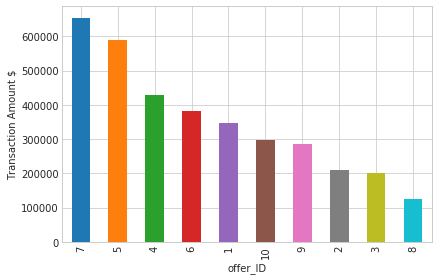

In [212]:
full_data.groupby('offer_ID')['amount'].sum().sort_values(ascending=False).plot(kind='bar')
plt.tight_layout()
plt.savefig('All offers type Transaction amount2.png', dpi=300)
plt.ylabel('Transaction Amount $')

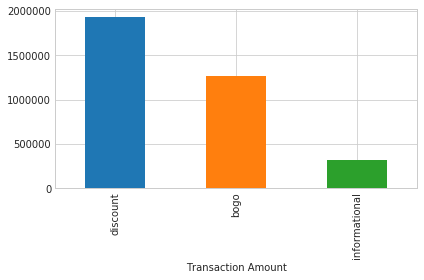

In [204]:
full_data.groupby('offer_type')['amount'].sum().sort_values(ascending=False).plot(kind='bar')
plt.tight_layout()
plt.savefig('Offr type Transaction amount.png', dpi=300)
plt.xlabel('Transaction Amount')
plt.show()

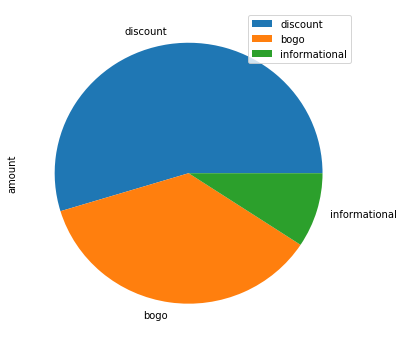

In [143]:
full_data.groupby('offer_type')['amount'].sum().sort_values(ascending=False).plot.pie(figsize=(6, 6),legend=True)

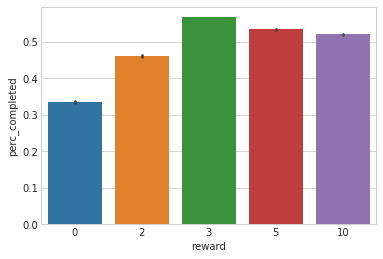

In [205]:
sb.barplot(y="perc_completed", x="reward", data=full_data)

In [206]:
full_data.groupby('gender')['income'].mean()#.unstack().plot(kind='box')#.unstack().plot(kind='box')

gender
F    71591.493760
M    61066.885930
O    61822.660099
Name: income, dtype: float64

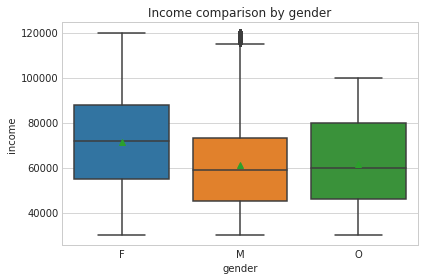

In [207]:
sb.boxplot(x="gender", y="income", data=full_data, showmeans=True)
sb.set_style("whitegrid")
plt.title("Income comparison by gender");
plt.tight_layout()
plt.savefig('Gender Income.png', dpi=300)
plt.show()

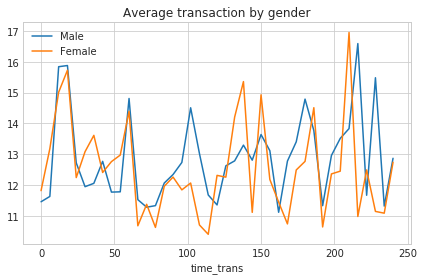

In [208]:
full_data[full_data.gender=='M'].groupby('time_trans')['amount'].mean().plot(legend=True,label='Male')
full_data[full_data.gender=='F'].groupby('time_trans')['amount'].mean().plot(legend=True,label='Female')
plt.title("Average transaction by gender");
plt.tight_layout()
plt.savefig('avg transaction.png', dpi=300)


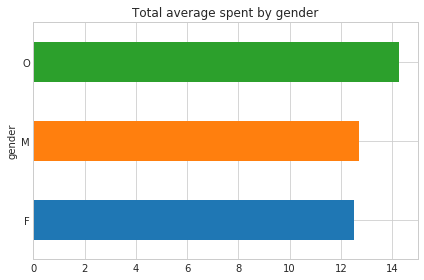

In [209]:
full_data.groupby('gender')['amount'].mean().plot(kind='barh')#,full_data[full_data.gender=='F']['amount'].mean()
plt.title("Total average spent by gender");
plt.tight_layout()
plt.savefig('Total Average by gender.png', dpi=300)

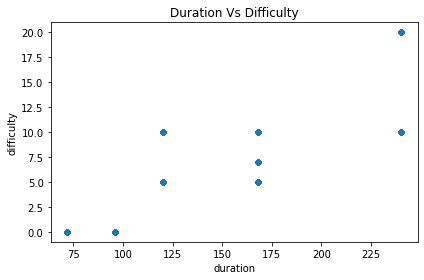

In [98]:
full_data.plot.scatter(x="duration", y="difficulty");
plt.title("Duration Vs Difficulty");
plt.tight_layout()
plt.savefig('Scatter duration difficulty.png', dpi=300)

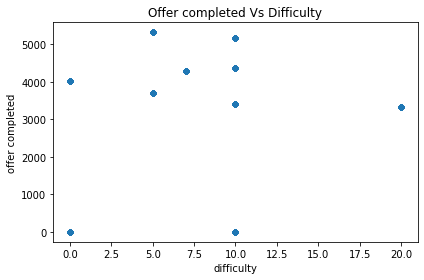

In [99]:
full_data.plot.scatter(x="difficulty", y="offer completed");
plt.title("Offer completed Vs Difficulty");
plt.tight_layout()
plt.savefig('Scatter completed difficulty.png', dpi=300)

In [221]:
full_data.customer_id.unique()

array([    1,     3,     5, ..., 13588, 13592, 13594])

In [220]:
full_data.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
age,278216.0,54.430820,17.365057,18.000000,43.000000,55.000000,67.000000,101.000000
income,278216.0,65433.497714,21527.889709,30000.000000,49000.000000,64000.000000,79000.000000,120000.000000
customer_id,278216.0,4768.229606,3228.030589,1.000000,2023.000000,4309.000000,7109.000000,13594.000000
time_trans,278216.0,91.459758,61.366095,0.000000,42.000000,84.000000,132.000000,240.000000
amount,278216.0,12.658961,29.723522,0.050000,2.800000,8.890000,17.890000,1001.850000
offer_time,278216.0,337.516627,206.317835,0.000000,168.000000,390.000000,504.000000,714.000000
offer_ID,278216.0,5.520520,2.592948,1.000000,4.000000,5.000000,7.000000,10.000000
offer completed,278216.0,3798.642069,1555.800875,0.000000,3331.000000,4296.000000,5156.000000,5317.000000
offer received,278216.0,7623.791187,33.881054,7571.000000,7593.000000,7618.000000,7646.000000,7677.000000
offer viewed,278216.0,6333.749461,1515.078925,2663.000000,6687.000000,7264.000000,7327.000000,7337.000000


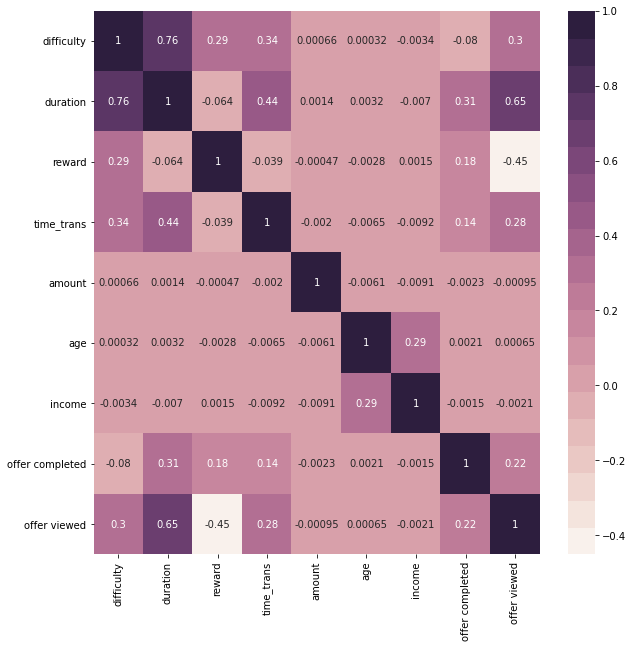

In [97]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(full_data[['difficulty','duration','reward','time_trans','amount','age','income','offer completed','offer viewed']].corr(), annot=True, cmap=sb.cubehelix_palette(20, light=0.95,dark=0.15))
plt.savefig('corr.png', bbox_inches='tight', dpi=300)

In [ ]:
df.property_type.value_counts()[:5].plot.pie(figsize=(6, 6),legend=True)
plt.savefig('type_property.png', bbox_inches='tight', dpi=300)